In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [45]:
df=pd.read_csv('CMI.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1973-02-21,0.0,5.562500,5.234375,5.234375,2.022768,18400
1,1973-02-22,0.0,5.328125,5.234375,5.281250,2.040883,31200
2,1973-02-23,0.0,5.281250,5.062500,5.062500,1.956350,29600
3,1973-02-26,0.0,5.093750,5.000000,5.000000,1.932197,21600
4,1973-02-27,0.0,5.031250,4.953125,4.953125,1.914082,12800


In [46]:
df.shape

(12960, 7)

In [47]:
df=df[['Date', 'Close']]
df['Date']=pd.to_datetime(df['Date'])

<Axes: xlabel='Date', ylabel='Close'>

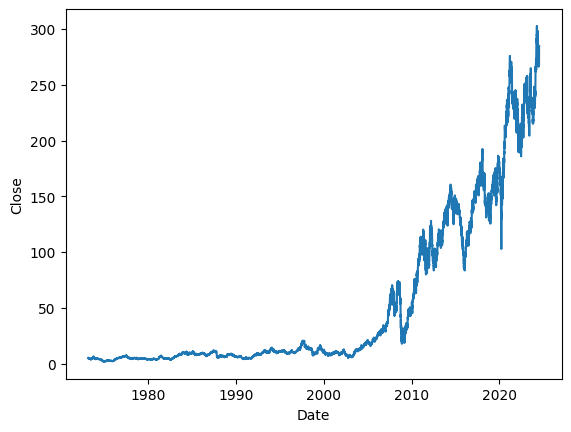

In [48]:
sns.lineplot(x=df['Date'], y=df['Close'])

In [49]:
print('min date: ', min(df['Date']))
print('max date: ', max(df['Date']))

min date:  1973-02-21 00:00:00
max date:  2024-07-12 00:00:00


In [50]:
train,test=df.loc[df['Date']<='2003-12-31'], df.loc[df['Date']>'2003-12-31']


In [51]:
train.head()

,Date,Close
0,1973-02-21,5.234375
1,1973-02-22,5.281250
2,1973-02-23,5.062500
3,1973-02-26,5.000000
4,1973-02-27,4.953125


In [52]:
scaler=StandardScaler()
scaler.fit(train[['Close']])

StandardScaler()

In [53]:
train[['Close']]=scaler.fit_transform(train[['Close']])
test[['Close']]=scaler.fit_transform(test[['Close']])


C:\Users\Harsh Vora\AppData\Local\Temp\ipykernel_29308\3105675253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['Close']]=scaler.fit_transform(train[['Close']])
C:\Users\Harsh Vora\AppData\Local\Temp\ipykernel_29308\3105675253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Close']]=scaler.fit_transform(test[['Close']])


In [54]:
seq_size=30 # number of steps to look back

In [55]:
def to_sequences(x, y, seq_size=1):
    x_values=[]
    y_values=[]

    for i in range (len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
    
    return np.array(x_values), np.array(y_values)

In [56]:
trainX, trainY= to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY= to_sequences(test[['Close']], test['Close'], seq_size)

In [57]:
trainX.shape

(7764, 30, 1)

In [58]:
trainY.shape

(7764,)

In [59]:
model=Sequential()

In [60]:
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [61]:
history=model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=False)

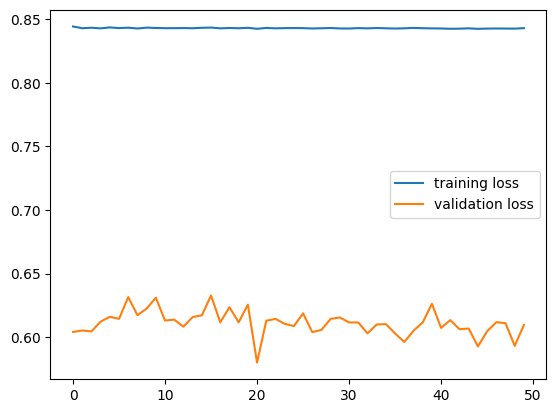

In [62]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

243/243 [==============================] - 5s 19ms/step


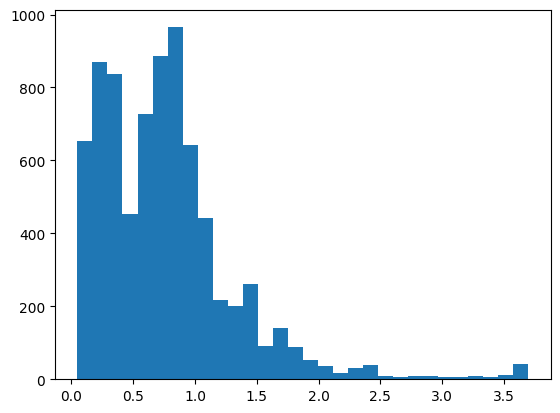

In [63]:
trainPredict=model.predict(trainX)
trainMAE=np.mean(np.abs(trainPredict-trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE=0.3 

161/161 [==============================] - 3s 15ms/step


(array([498., 310., 361., 326., 287., 169., 296., 261., 214., 194., 204.,
         52., 196., 290., 357., 291.,  52., 110., 113., 136.,  99.,  99.,
         60.,  18.,  64.,   4.,  10.,  18.,  17.,  30.]),
 array([0.02559886, 0.10442486, 0.18325085, 0.26207684, 0.34090284,
        0.41972883, 0.49855482, 0.57738082, 0.65620681, 0.7350328 ,
        0.8138588 , 0.89268479, 0.97151078, 1.05033678, 1.12916277,
        1.20798876, 1.28681476, 1.36564075, 1.44446674, 1.52329274,
        1.60211873, 1.68094472, 1.75977072, 1.83859671, 1.9174227 ,
        1.99624869, 2.07507469, 2.15390068, 2.23272667, 2.31155267,
        2.39037866]),
 <BarContainer object of 30 artists>)

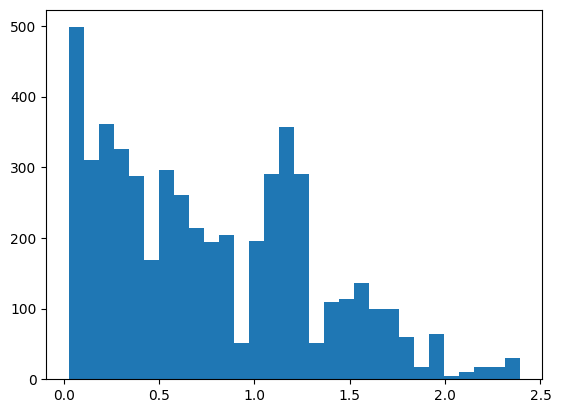

In [68]:
testPredict=model.predict(testX)
testMAE=np.mean(np.abs(testPredict-testX), axis=1)
plt.hist(testMAE, bins=30)

In [69]:
#CAPTURE ANOMALIES IN A DATAFRAME
anomaly_df=pd.DataFrame(test[seq_size:])
anomaly_df['testMAE']=testMAE
anomaly_df['max_trainMAE']=max_trainMAE
anomaly_df['anomaly']=anomaly_df['testMAE']>anomaly_df['max_trainMAE']
anomaly_df['Close']=test[seq_size:]['Close']

<Axes: xlabel='Date', ylabel='testMAE'>

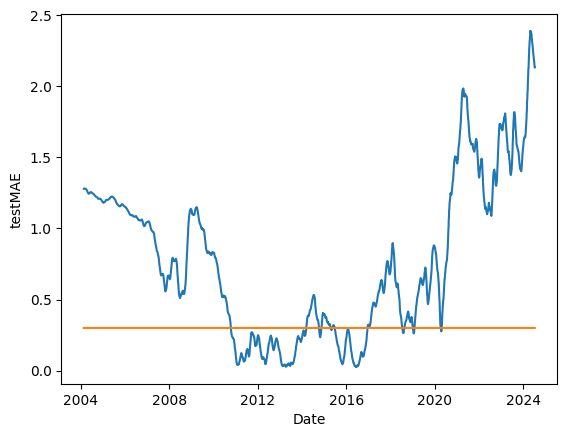

In [70]:
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [71]:
anomalies=anomaly_df.loc[anomaly_df['anomaly']==True]

In [81]:
y=scaler.inverse_transform(anomaly_df[['Close']])
y

array([[ 13.1825  ],
       [ 12.95    ],
       [ 12.84    ],
       ...,
       [274.089996],
       [280.040009],
       [284.859985]])

In [ ]:
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')